<a href="https://colab.research.google.com/github/olusegunadelowo/Forecasting-Household-Electricity-Consumption-with-Time-Series-Model/blob/main/Time_Series_Analysis_Electricity_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# 2. Import Dataset

In [ ]:
#Mounting the content of google drive (the content includes our dataset)
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#importing the dataset from google drive
Energy_data = pd.read_csv("/content/gdrive/MyDrive/Data Science Projects/hamoyeInternship/Stage E - Time Series /household_power_consumption.csv",
                           sep=';', low_memory=False)

# 3. Data Wrangling

In [ ]:
#Preview the 1st 7 rows of the table
Energy_data.head(7)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0


In [ ]:
#Check shape of the data
Energy_data.shape

(2075259, 9)

## 3.1 Convert to datetime format YYYY-MM-DD HH:MM:SS

In [ ]:
#merge the date and time columns and form a new column called DateTime
Energy_data["DateTime"] = Energy_data["Date"] +" "+ Energy_data["Time"]
#delete Date and Time Columns
Energy_data.drop(Energy_data.iloc[:, 0:2], inplace=True, axis=1)
#convert DateTime column to datetime format YYYY-MM-DD HH:MM:SS
Energy_data["DateTime"] = pd.to_datetime(Energy_data["DateTime"])
#Convert DateTime column to index
Energy_data.set_index("DateTime", inplace=True)
#Preview the 1st 7 observations
Energy_data.head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
2006-12-16 17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
2006-12-16 17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0


## 3.2 Treat missing values and Change Columns' Datatypes

In [ ]:
#check for missing values
Energy_data.isnull().values.any()

True

`Observation` : There are missing values

In [ ]:
#Check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


`Observation` : On the CSV file, all columns protrayed as object/string are actually not.They are showing as object because of the presence of a string '?'

In [ ]:
#replace ? with 0
Energy_data = Energy_data.replace('?', 0)

In [ ]:
#check sum of missing data
Energy_data.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

`Observation` : Sub_metering_3 has missing values of 25979

In [ ]:
#Filling missing data by imputation - Forward fill
Energy_data = Energy_data.fillna(method='ffill')
Energy_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
#Convert all columns to float data types
Energy_data = Energy_data.astype(float)

In [ ]:
#Re-check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


Text(0, 0.5, 'Global_active_power')

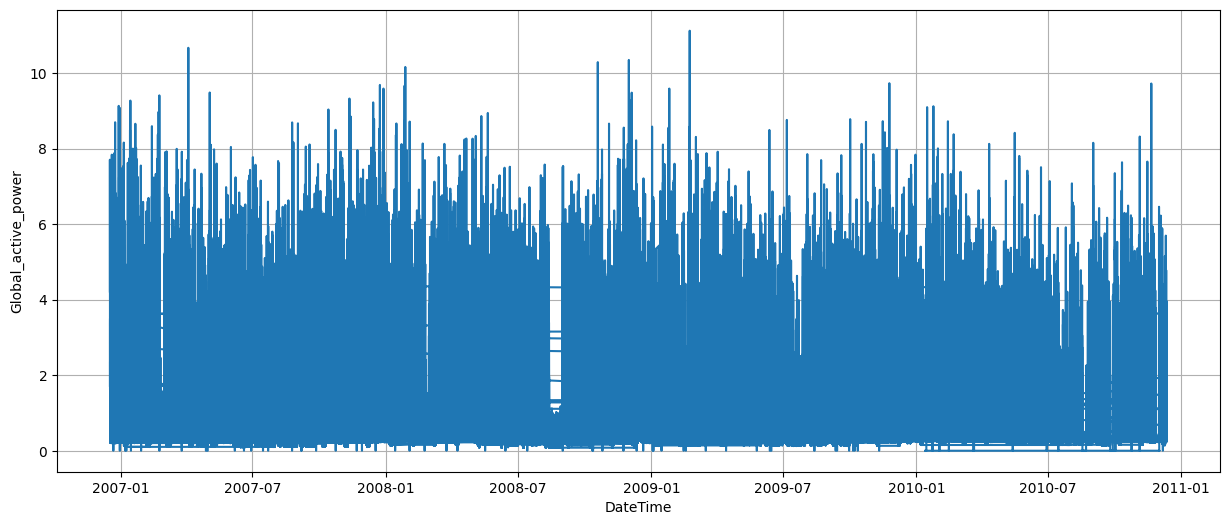

In [ ]:
#time-series plot of Global_active_power reading against time

plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Global_active_power)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')

`Observation`: It's difficult to recognize patterns because our dataset has too many samples 1048576

## 3.3 Outliers detection and treatment

<Axes: title={'center': 'Distribution of Global_active_power Readings'}>

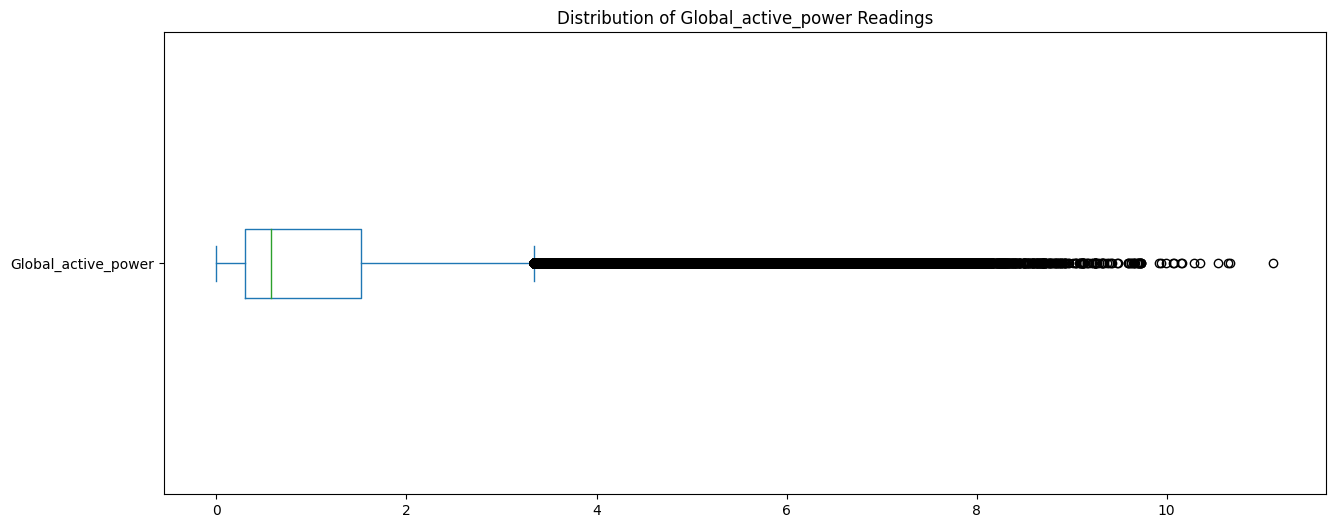

In [ ]:
#create a boxplot to detect the presence of outliers
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Global_active_power"].plot(kind="box" , vert = False, title = "Distribution of Global_active_power Readings" , ax = ax)

`Observations`: Our target variable "voltage" has a lot of outliers

In [ ]:
#Remove outlier
Energy_data = Energy_data[Energy_data["Global_active_power"] < 10]  #mask to remove outlier with value of Global_active_power greater than 10

<Axes: title={'center': 'Distribution of Global_active_power Readings'}>

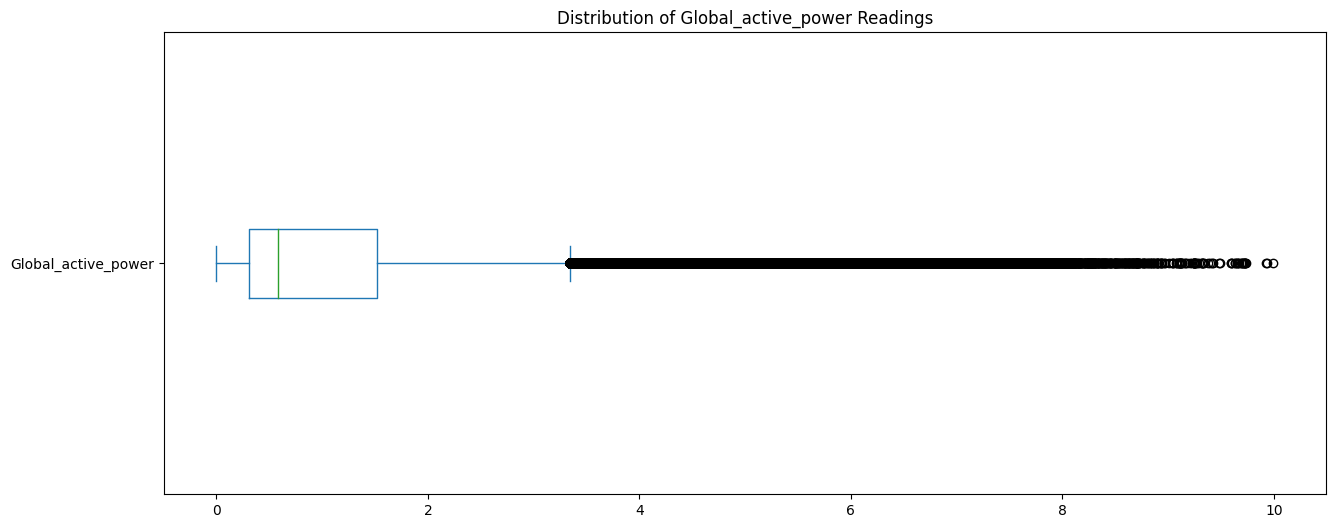

In [ ]:
#check if outliers have been removed
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Global_active_power"].plot(kind="box" , vert = False, title = "Distribution of Global_active_power Readings" , ax = ax)

Text(0, 0.5, 'Global_active_power')

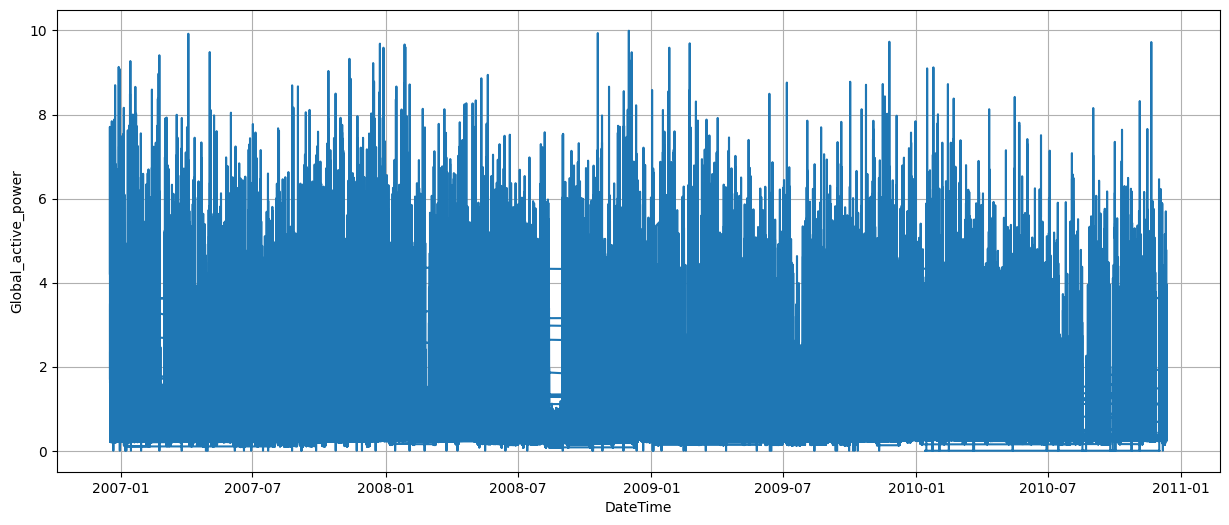

In [ ]:
#plot Global_active_power against datetime after outlier removal
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Global_active_power)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')

`Observations`: The pattern became less congested with the removal of outliers

## 3.4 Resampling Target Variable

In [ ]:
#resampling(downsampling) for Global_active_power readings to be 6months
Energy_data["Global_active_power"].resample("D").mean().head(7)

DateTime
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
2006-12-21    1.192100
2006-12-22    1.625929
Freq: D, Name: Global_active_power, dtype: float64

In [ ]:
#Find out how many missing values
Energy_data["Global_active_power"].resample("D").mean().isnull().sum()

15

In [ ]:
#Check that their's not missing value again
Energy_data["Global_active_power"].resample("D").mean().fillna(method = "ffill").head().isnull().sum()

0

Text(0, 0.5, 'Global_active_power')

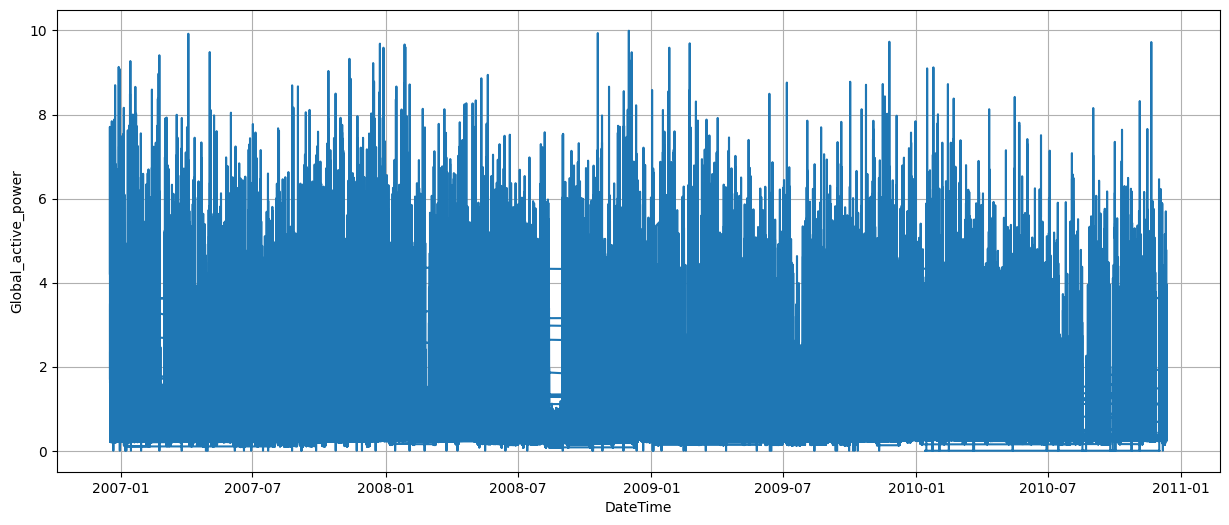

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Global_active_power)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')

`Observation`: The undersampling of target variable does not have any effect on the pattern.The pattern remained the same

## 3.5 Moving average smoothing

In [ ]:
#Rolling average to smoothen time-series data using 1 week interval.Smoothen graph enables to see hidden trend
Energy_data["Global_active_power"].rolling(168).mean()

DateTime
2006-12-16 17:24:00         NaN
2006-12-16 17:25:00         NaN
2006-12-16 17:26:00         NaN
2006-12-16 17:27:00         NaN
2006-12-16 17:28:00         NaN
                         ...   
2010-11-26 20:58:00    1.492214
2010-11-26 20:59:00    1.491893
2010-11-26 21:00:00    1.490167
2010-11-26 21:01:00    1.487107
2010-11-26 21:02:00    1.484060
Name: Global_active_power, Length: 2075249, dtype: float64

In [ ]:
#1st 168h in the window has missing value
Energy_data["Global_active_power"].rolling(168).mean().isnull().sum()

167

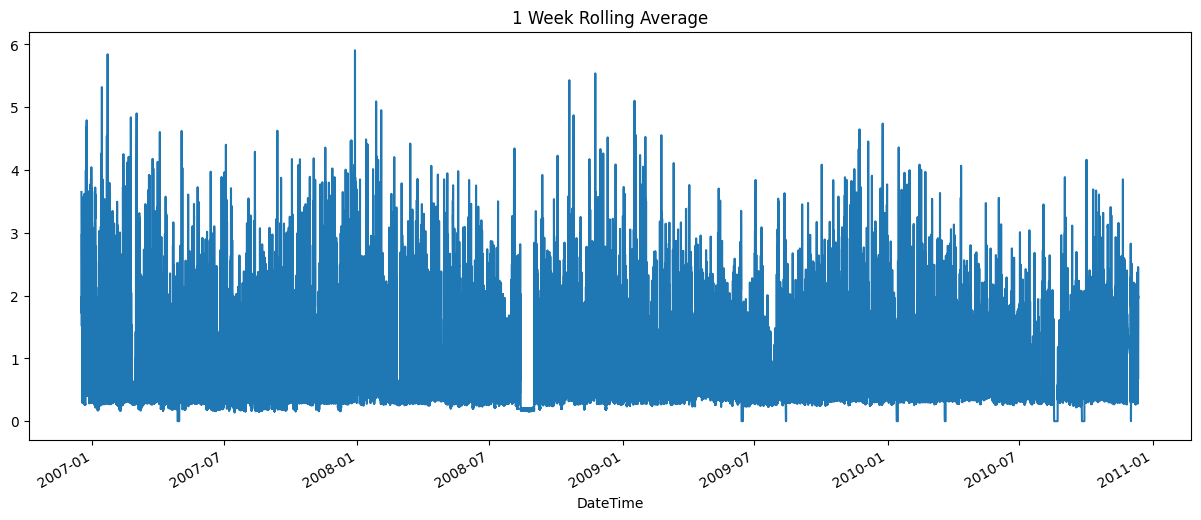

In [ ]:
#smoothens the pattern with 1 week rolling average
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Global_active_power"].rolling(168).mean().plot(ax=ax, label="Global_active_power" , title = "1 Week Rolling Average");

# 4. Exploratory Data Analysis

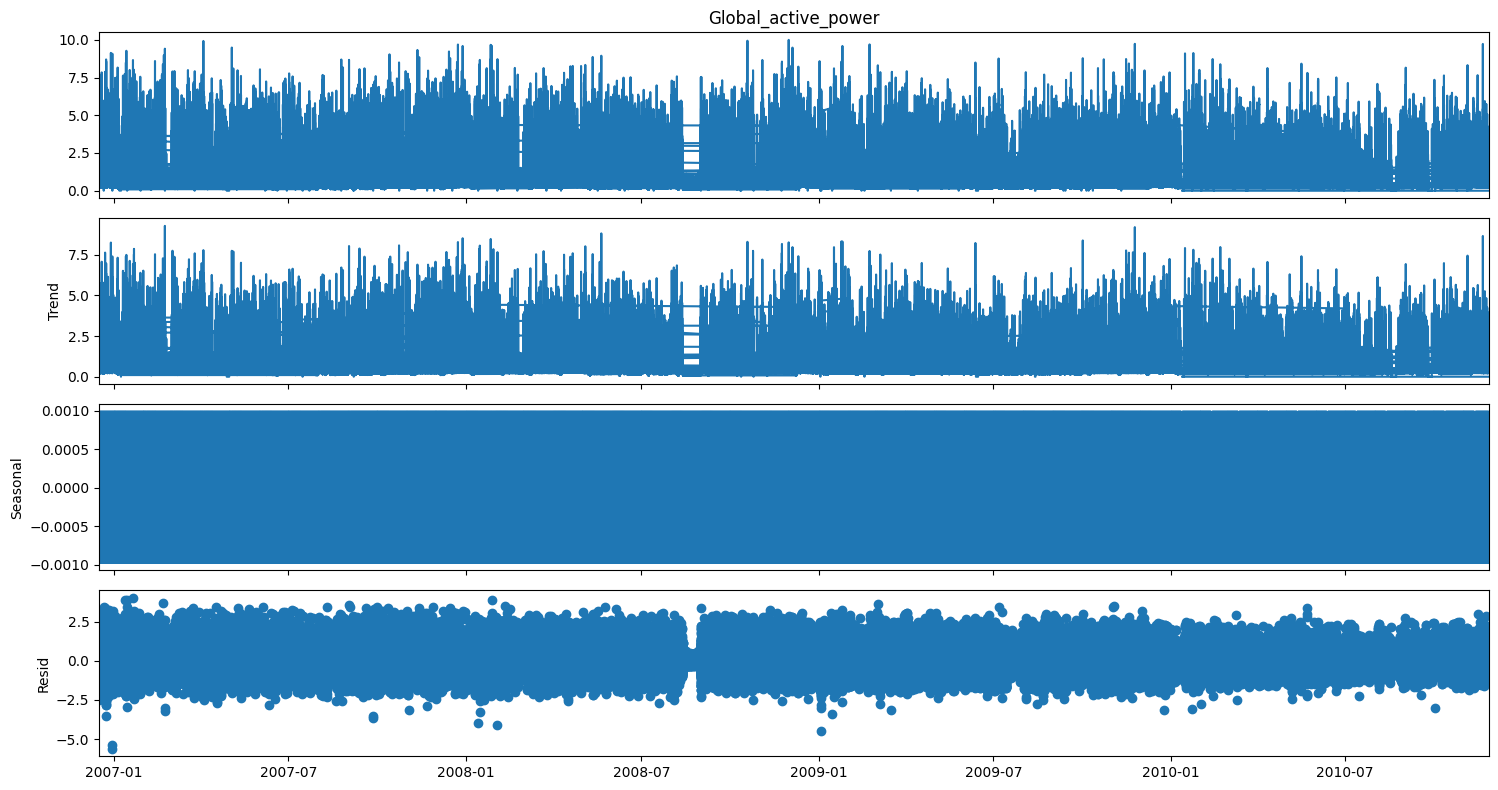

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(Energy_data['Global_active_power'], model='additive', period=10)
decompose_series.plot()
plt.show()

In [ ]:
#performs an ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(Energy_data['Voltage'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}')

# 4 Feature Engineering

In [ ]:
# create a lag of the target variable Global_active_power
Energy_data["Global_active_power.L1"]= Energy_data["Global_active_power"].shift(1)
Energy_data.head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power.L1
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,4.216
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.360
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,3.666
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,3.520


In [ ]:
# Delete missing data Global_active_power.L1 column
Energy_data.dropna().head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power.L1
DateTime,,,,,,,,
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,4.216
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.360
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5.374
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5.388
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,3.666
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,3.520
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0,3.702


In [ ]:
#autocorrelation between target feature Global_active_power and predictor Global_active_power-L1
Energy_data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power.L1
Global_active_power,1.000000,0.257531,0.066551,0.998903,0.483323,0.434191,0.636824,0.968288
Global_reactive_power,0.257531,1.000000,0.107713,0.276459,0.124624,0.141158,0.093953,0.249370
Voltage,0.066551,0.107713,1.000000,0.066139,-0.003132,0.004805,0.011981,0.067405
Global_intensity,0.998903,0.276459,0.066139,1.000000,0.488150,0.439897,0.624918,0.966963
Sub_metering_1,0.483323,0.124624,-0.003132,0.488150,1.000000,0.054950,0.103007,0.458551
Sub_metering_2,0.434191,0.141158,0.004805,0.439897,0.054950,1.000000,0.081574,0.416255
Sub_metering_3,0.636824,0.093953,0.011981,0.624918,0.103007,0.081574,1.000000,0.632599
Global_active_power.L1,0.968288,0.249370,0.067405,0.966963,0.458551,0.416255,0.632599,1.000000


`Observation`: Target variable (Voltage) and its lag (Voltage.L1) has excellent positve correlation of 0.96

Text(0.5, 1.0, 'Global_active_power Autocorrelation')

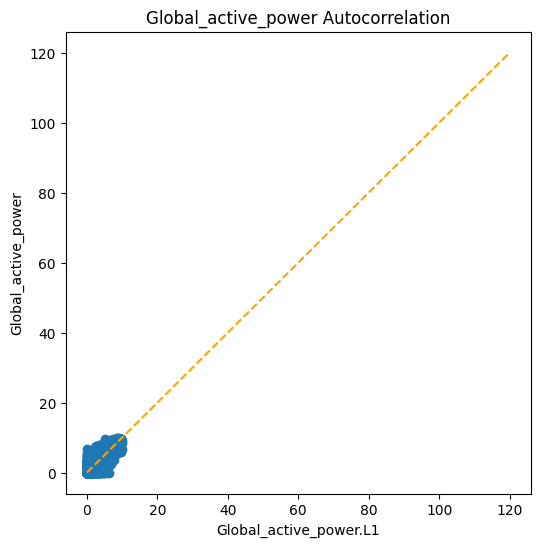

In [ ]:
#Plot of Global_active_power andGlobal_active_power.L1
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=Energy_data["Global_active_power.L1"], y=Energy_data["Global_active_power"])
ax.plot([0,120], [0,120] , linestyle="--", color = "orange")
plt.xlabel("Global_active_power.L1")
plt.ylabel("Global_active_power")
plt.title("Global_active_power Autocorrelation")

# 5 Build Linear Regression Model

## 5.1 Split Data

In [ ]:
#List columns in the dataset
Energy_data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Global_active_power.L1'],
      dtype='object')

In [ ]:
#split data into x and y
y = Energy_data["Global_active_power"]   #target
X = Energy_data.drop(columns=['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'])   #predictor

In [74]:
#cut-off splitting apllicable to time-series data
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

## 5.2 Baseline Model

In [76]:
y_mean = y_train.mean()
y_pred_baseline =[y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean Global_active_power Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Global_active_power Reading: 1.1
Baseline MAE: 0.85


## 5.3 Linear (Ridge) Regression Model

In [77]:
#treating missing values in X_train
imputer = SimpleImputer()
imputer.fit(X_train)
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660199 entries, 0 to 1660198
Data columns (total 1 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Global_active_power.L1  1660199 non-null  float64
dtypes: float64(1)
memory usage: 12.7 MB


In [78]:
#Instantiate an object of the class LinearRegression as model
model_reg = make_pipeline(SimpleImputer(), LinearRegression())
model_reg.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [79]:
#Model predictions with ridge
y_pred_train_1 = model_reg.predict(X_train)
y_pred_test_1 = model_reg.predict(X_test)

In [80]:
#Compare Model performance
training_mae = mean_absolute_error(y_pred_train_1 , y_train)
test_mae = mean_absolute_error(y_pred_test_1 , y_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.1
Test MAE: 0.08


## 5.4 Train Ridge Model

In [81]:
#Model train with ridge
model_ridge = make_pipeline(SimpleImputer(), Ridge())
model_ridge.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [82]:
#Model predictions with ridge
y_pred_train_2 = model_ridge.predict(X_train)
y_pred_test_2 = model_ridge.predict(X_test)

## 5.5 Ridge Performance Metric

In [83]:
#Compare Model performance
training_mae = mean_absolute_error(y_pred_train_2 , y_train)
test_mae = mean_absolute_error(y_pred_test_2 , y_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.1
Test MAE: 0.08


`Observation`: The model generalizes well on an unseen data (test data).
               Both Linear Regression and Ridge have the same MAE of 0.38 with an unseen data

In [84]:
df_pred_test = pd.DataFrame({"y_test":y_test ,"y_pred_test":model_reg.predict(X_test)})
df_pred_test.head(10)

,y_test,y_pred_test
DateTime,,
2010-11-02 15:33:00,0.334,0.358782
2010-11-02 15:34:00,0.336,0.358782
2010-11-02 15:35:00,0.334,0.360718
2010-11-02 15:36:00,0.332,0.358782
2010-11-02 15:37:00,0.394,0.356847
2010-11-02 15:38:00,0.406,0.416853
2010-11-02 15:39:00,0.412,0.428467
2010-11-02 15:40:00,0.414,0.434275
2010-11-02 15:41:00,0.412,0.436210
